In [3]:
import json
import pandas as pd
import numpy as np
from h3 import h3
from collections import Counter
import matplotlib.pyplot as plt
from functools import partial
from tabulate import tabulate

# Read the datasets

In [4]:
def print_tabulate(df):
        if isinstance(df, pd.DataFrame):
            print(tabulate(df, headers='keys', tablefmt='psql'))
        else:
            return df

In [6]:
pois = pd.read_csv("data/pois.csv")
outlets = pd.read_csv("data/outlets.csv")

In [7]:
pois.columns

Index(['lat', 'lng', 'category'], dtype='object')

In [8]:
print_tabulate(outlets)

+----+---------+---------+------------+
|    |     lat |     lng | category   |
|----+---------+---------+------------|
|  0 | 6.26009 | 80.214  | outlet-A   |
|  1 | 6.20141 | 80.2907 | outlet-B   |
|  2 | 6.12257 | 80.3354 | outlet-C   |
|  3 | 6.08519 | 80.44   | outlet-D   |
|  4 | 6.21761 | 80.4301 | outlet-E   |
+----+---------+---------+------------+


In [9]:
print_tabulate(pois.head())

+----+---------+---------+---------------------+
|    |     lat |     lng | category            |
|----+---------+---------+---------------------|
|  0 | 6.27794 | 80.3655 | hospitals           |
|  1 | 6.21386 | 80.2322 | hospitals           |
|  2 | 6.23051 | 80.3855 | tourist attractions |
|  3 | 6.21106 | 80.385  | police stations     |
|  4 | 6.11425 | 80.4201 | tourist attractions |
+----+---------+---------+---------------------+


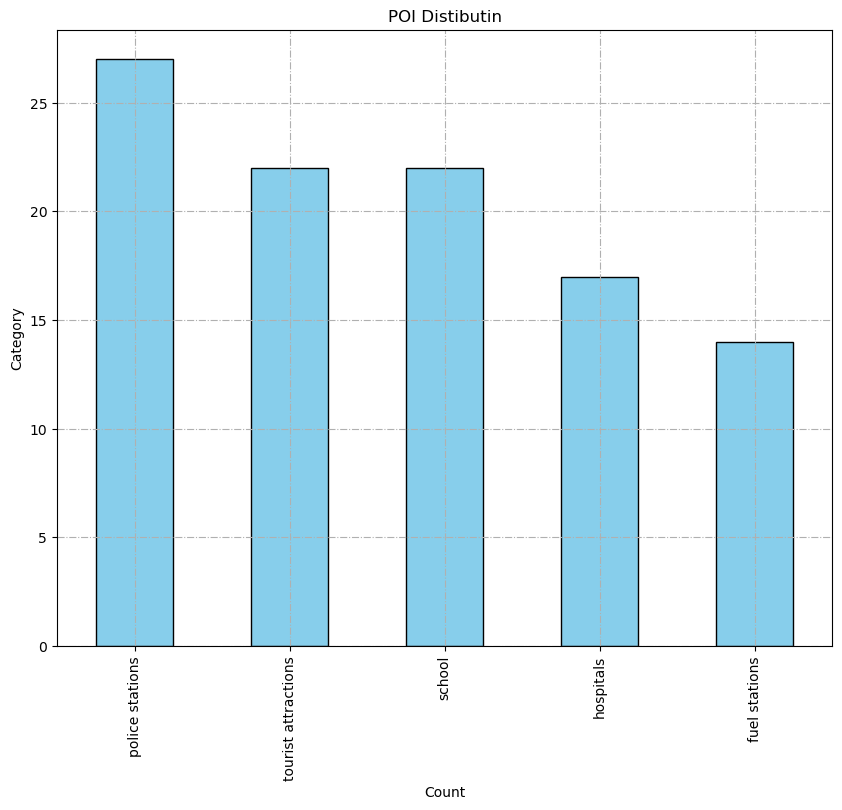

In [10]:
pois['category'].value_counts().plot.bar(color='skyblue',edgecolor='black',figsize=(10,8))
plt.title("POI Distibutin")
plt.xlabel("Count")
plt.ylabel("Category")
plt.grid(visible=True, linestyle='-.')
plt.show()

In [16]:
from utils import add_h3_cell,dict_to_shapely,polygon_to_h3

In [17]:
outlets_h3 = add_h3_cell(outlets,resolution=8)
pois_h3 = add_h3_cell(pois,resolution=8)

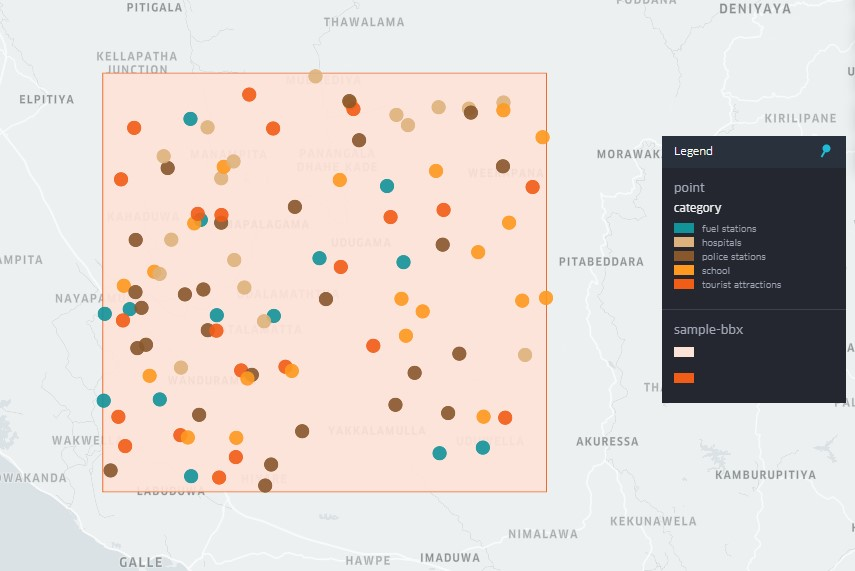

# Splitting region into hexagons

In [19]:
with open("data/sample-bbx.geojson",'r') as f:
    polygon_dict = json.loads(f.read())
    shapely_polygon = dict_to_shapely(polygon_dict)
    f.close()

In [20]:
??polygon_to_h3

Signature: polygon_to_h3(polygon, resolution)
Docstring: <no docstring>
Source:   
def polygon_to_h3(polygon,resolution):
    polygon = mapping(polygon)
    hexas = h3.polyfill(polygon,res=resolution,geo_json_conformant=True)
    return list(set(hexas))
File:      c:\users\ransaka_09914\desktop\medium article\indexing\utils.py
Type:      function


In [21]:
h3_idx = polygon_to_h3(shapely_polygon,resolution=8)

In [22]:
len(h3_idx)

912

In [23]:
h3_idx = pd.DataFrame(pd.Series(h3_idx,name='h3'))
# h3_idx.to_csv("h3_idx.csv",index=False)

<img src='images/Screenshot 2023-01-24 141722.jpg'>

# Deriving score for each hexagon in the region

In [24]:
#define the weights for each poi type
scores = 1- (pois['category'].value_counts(normalize=True)) * 3
scores_dict = dict(zip(scores.index,scores.values * 100))

In [25]:
pois['weight'] = pois['category'].map(scores_dict)

In [26]:
grouped_df = pois.groupby("h3").agg(
    counts=('category','count'),
    score = ('weight','sum')
).sort_values(by='counts',ascending=False)

In [27]:
print_tabulate(grouped_df.head())

+-----------------+----------+---------+
| h3              |   counts |   score |
|-----------------+----------+---------|
| 886103da85fffff |        2 | 94.1176 |
| 886103db23fffff |        2 | 55.8824 |
| 886102ac5bfffff |        2 | 85.2941 |
| 886103d853fffff |        2 | 85.2941 |
| 886103d159fffff |        2 | 70.5882 |
+-----------------+----------+---------+


<img src='images/Screenshot 2023-01-24 144451.jpg'>

<img src='images/Screenshot 2023-01-24 150523.jpg'>

In [30]:
grouped_df.reset_index(inplace=True)

In [31]:
full_scored_idx = h3_idx.merge(grouped_df,on='h3',how='left').fillna(0)

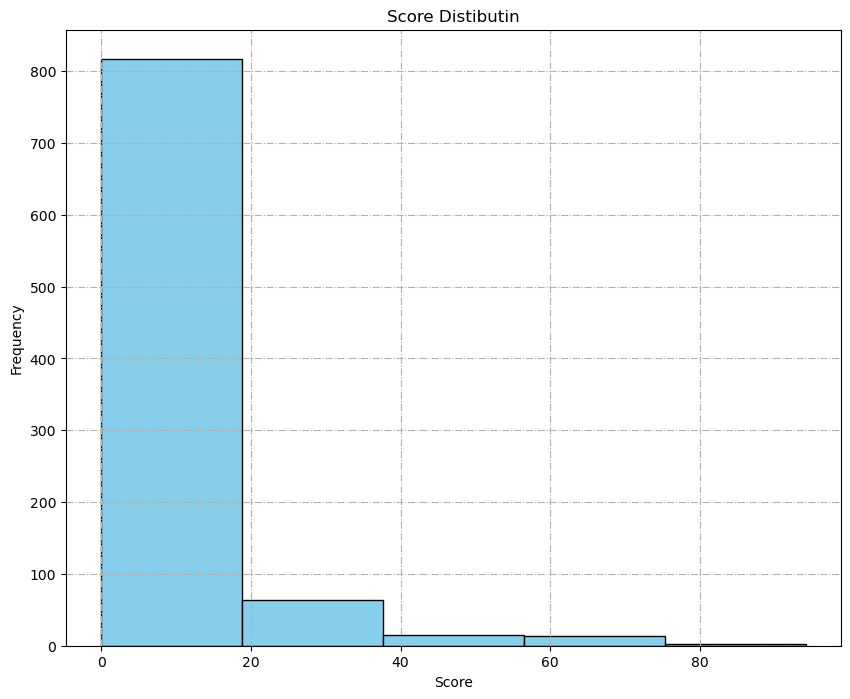

In [32]:
full_scored_idx['score'].plot.hist(color='skyblue',edgecolor='black',bins=5,figsize=(10,8))
plt.title("Score Distibutin")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.grid(visible=True, linestyle='-.')
plt.show()

<img src='images/Screenshot 2023-01-24 154437.jpg'>

<img src='images/Screenshot 2023-01-24 154501.jpg'>

# define rearby k cells per outlet

In [33]:
h3_to_score = dict(zip(full_scored_idx['h3'],full_scored_idx['score']))

In [34]:
get_krings = lambda h:h3.k_ring(h,k=3)

In [35]:
outlets_h3['rings'] = outlets_h3['h3'].apply(get_krings)

In [36]:
outlets_h3['category'] = [f"outlet-{a}" for a in ["A","B","C","D","E"]]

In [37]:
outlets_h3[['category','h3','rings']]

,category,h3,rings
0,outlet-A,886103d8d5fffff,"{886103d8c3fffff, 886103dab7fffff, 886103d88bf..."
1,outlet-B,886103da57fffff,"{886103da09fffff, 886103da03fffff, 886103da01f..."
2,outlet-C,886102a6b3fffff,"{886102a4d7fffff, 886102a4d5fffff, 886102a4c9f..."
3,outlet-D,886102a649fffff,"{886102a647fffff, 886102a669fffff, 886102a659f..."
4,outlet-E,886102a505fffff,"{886102a521fffff, 886102a503fffff, 886102a531f..."


In [38]:
outlets_exploded = outlets_h3.explode(column='rings')

In [39]:
outlets_exploded['weight'] = outlets_exploded['rings'].map(h3_to_score)

In [40]:
#can contains hexagons not relavent to current region
outlets_exploded.dropna(inplace=True)

In [41]:
print_tabulate(outlets_exploded.groupby("category").agg(outlet_importance=("weight",'sum')))

+------------+---------------------+
| category   |   outlet_importance |
|------------+---------------------|
| outlet-A   |            141.176  |
| outlet-B   |            158.824  |
| outlet-C   |             20.5882 |
| outlet-D   |              0      |
| outlet-E   |             70.5882 |
+------------+---------------------+


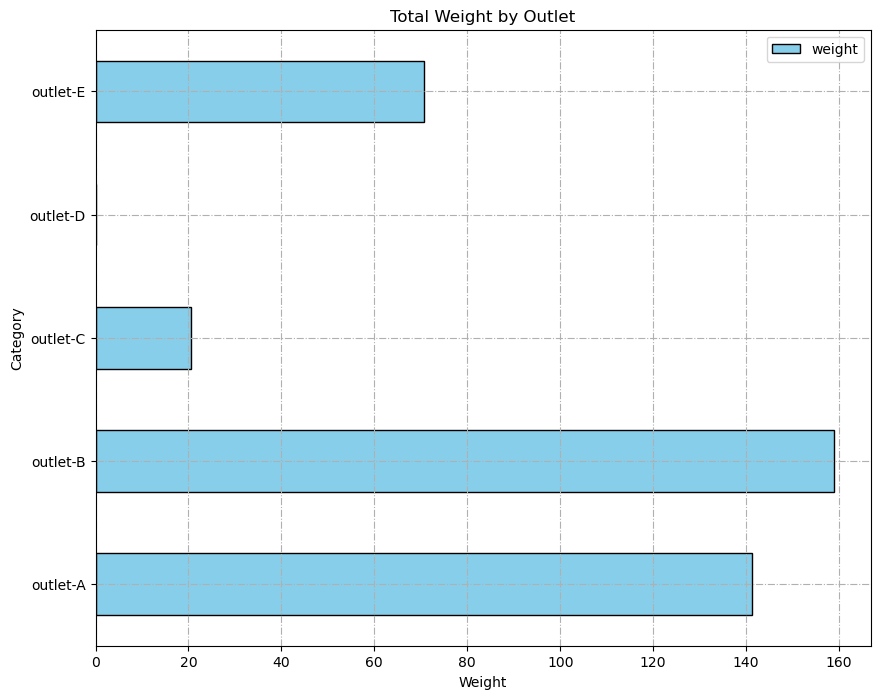

In [42]:
outlets_exploded.groupby("category").agg({"weight":sum}).plot.barh(color='skyblue',edgecolor='black',figsize=(10,8))
plt.title("Total Weight by Outlet")
plt.xlabel("Weight")
plt.ylabel("Category")
plt.grid(visible=True, linestyle='-.')
plt.show()